In [1]:
import sys, time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

In [2]:
sys.path.append("../../src")
from models import MLP
from data import gen_rnd_ds
from losses import LinearClassification, SquaredClassification

from torchessian.plotting import plot_leading_eigen
from torchessian import batch_hessian_eigen
from hessian_eigenthings import compute_hessian_eigenthings
from derivation  import analytic_hessian_eigen

## Helpers

In [3]:
def dot(a, b):
    return a.mm(b.t())
    
def orthogonality(x, y=None):
    """
    """
    if y is not None:
        x = dot(x, y)
    return 1-((x.diag()**2).sum() / (x**2).sum()).item()

def dimesion_match(app_vec, exact_vec):
    """
    """
    return app_vec.mm(exact_vec[:app_vec.shape[0]].t()).abs().max(0)

def sort_approx(app_vec, app_val, exact_vec, exact_val):
    """
    """
    score, idx = dimesion_match(app_vec, exact_vec)
    app_vec = app_vec[idx]
    app_val = app_val[idx]
    return app_vec, app_val

def align_and_compare(app_vec, app_val, exact_vec, exact_val, neigen=None):
    ort_err = orthogonality(app_vec, app_vec)
    app_vec, app_val = sort_approx(app_vec, app_val, exact_vec, exact_val)
    neigen = min(neigen, app_val.shape[0]) or app_val.shape[0]
    app_vec, app_val, exact_vec, exact_val = \
        app_vec[:neigen], app_val[:neigen], exact_vec[:neigen], exact_val[:neigen]
        
    mat  = dot(app_vec, exact_vec).abs()
    vec_err = orthogonality(mat)
    val_err = ((app_val-exact_val)**2).mean().item()
    return ort_err, vec_err, val_err, mat, app_val

## Default Parameters

In [4]:
# Model
mode = "relu"
bias = False
nlayer = 2
inp_dim = 10 
out_dim = 10
hid_dim = 10

# Data parameters
nsamp = 5000
inp_mean = 0
inp_var = 1

# Others
device = 0
lr = 1
Neigen = 50

# Benchmark Torch Hessian

1. Basics
2. Impact of number of components
3. Impact of network size (width)
4. Impact of network size (depth)

## 1. Basis

In [5]:
model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
               out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)

0.9249985218048096


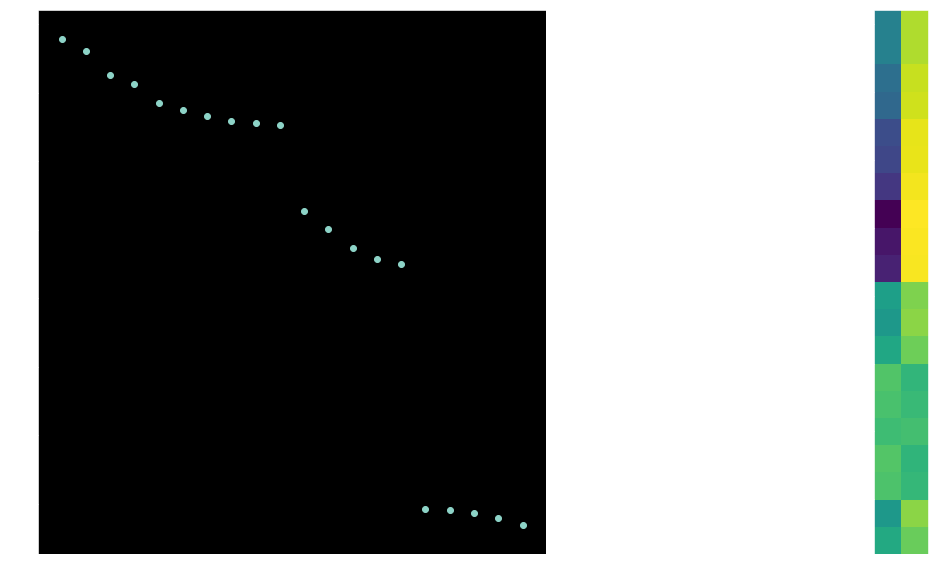

In [6]:
a_eig_val, a_eig_vec = analytic_hessian_eigen(model, ds, loss_fn)
plot_leading_eigen(a_eig_val, a_eig_vec, model)

 41%|████      | 20/49 [00:00<00:00, 198.17it/s]

[Complete LANCZOS Algorithm running]


100%|██████████| 49/49 [00:00<00:00, 128.76it/s]


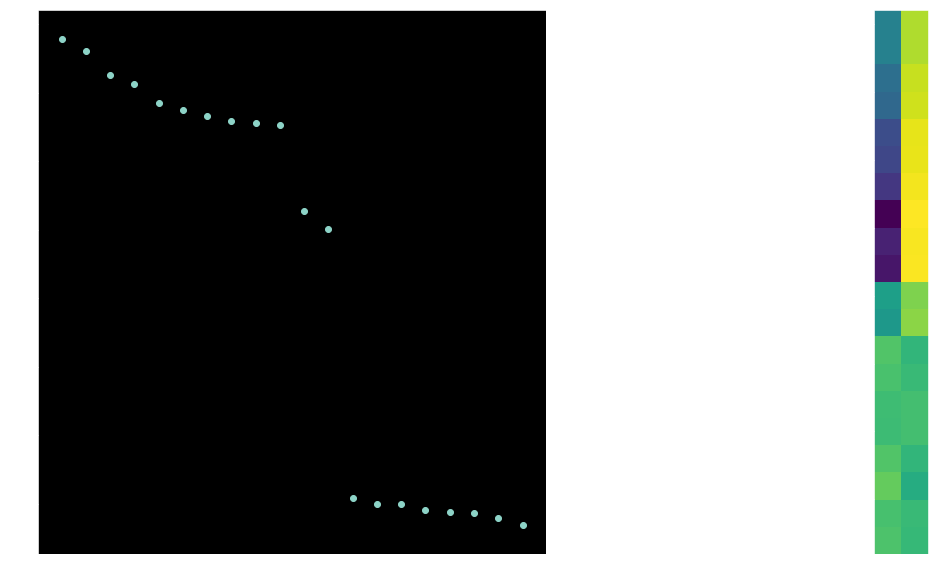

In [7]:
b_eig_val, b_eig_vec = batch_hessian_eigen(model, ds, loss_fn, Neigen)
plot_leading_eigen(b_eig_val, b_eig_vec, model)

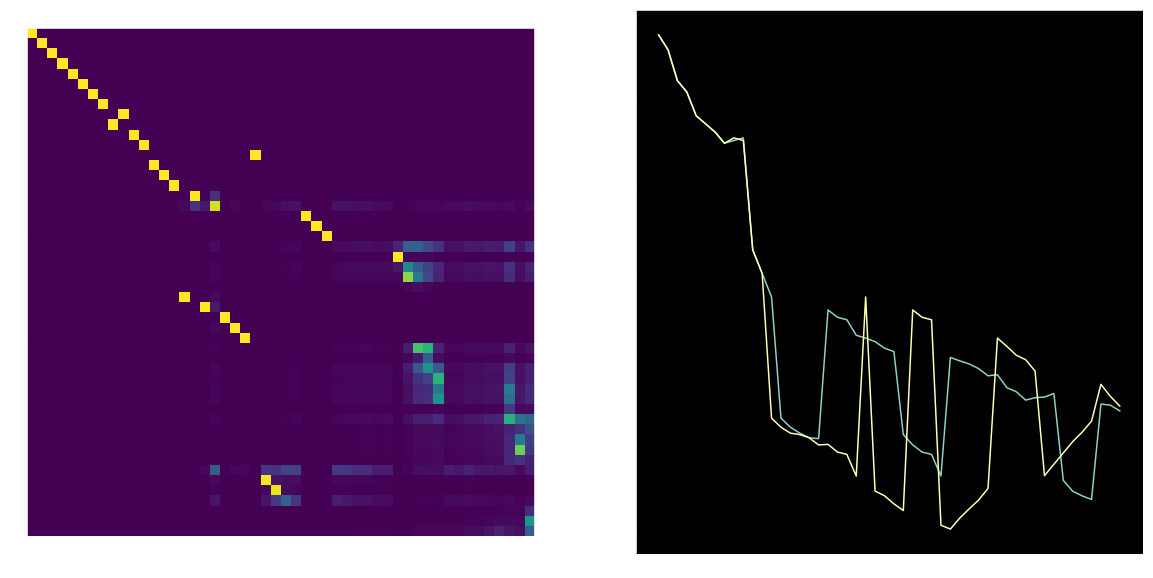

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(a_eig_vec[:Neigen].mm(b_eig_vec.t()).abs())
ax[1].plot(a_eig_val[:Neigen].abs().cpu().numpy())
ax[1].plot(b_eig_val[:Neigen].abs().cpu().numpy())

## 2. Impact of number of components 

In [11]:
# Exp parameters
N = 50
neigens = [10, 20, 40, 80, 160]

  0%|          | 0/39 [00:00<?, ?it/s]

[Complete LANCZOS Algorithm running]
[Complete LANCZOS Algorithm running]
[Complete LANCZOS Algorithm running]


 29%|██▉       | 23/79 [00:00<00:00, 226.37it/s]

[Complete LANCZOS Algorithm running]


 14%|█▍        | 22/159 [00:00<00:00, 209.76it/s]

[Complete LANCZOS Algorithm running]


100%|██████████| 159/159 [00:02<00:00, 62.96it/s]


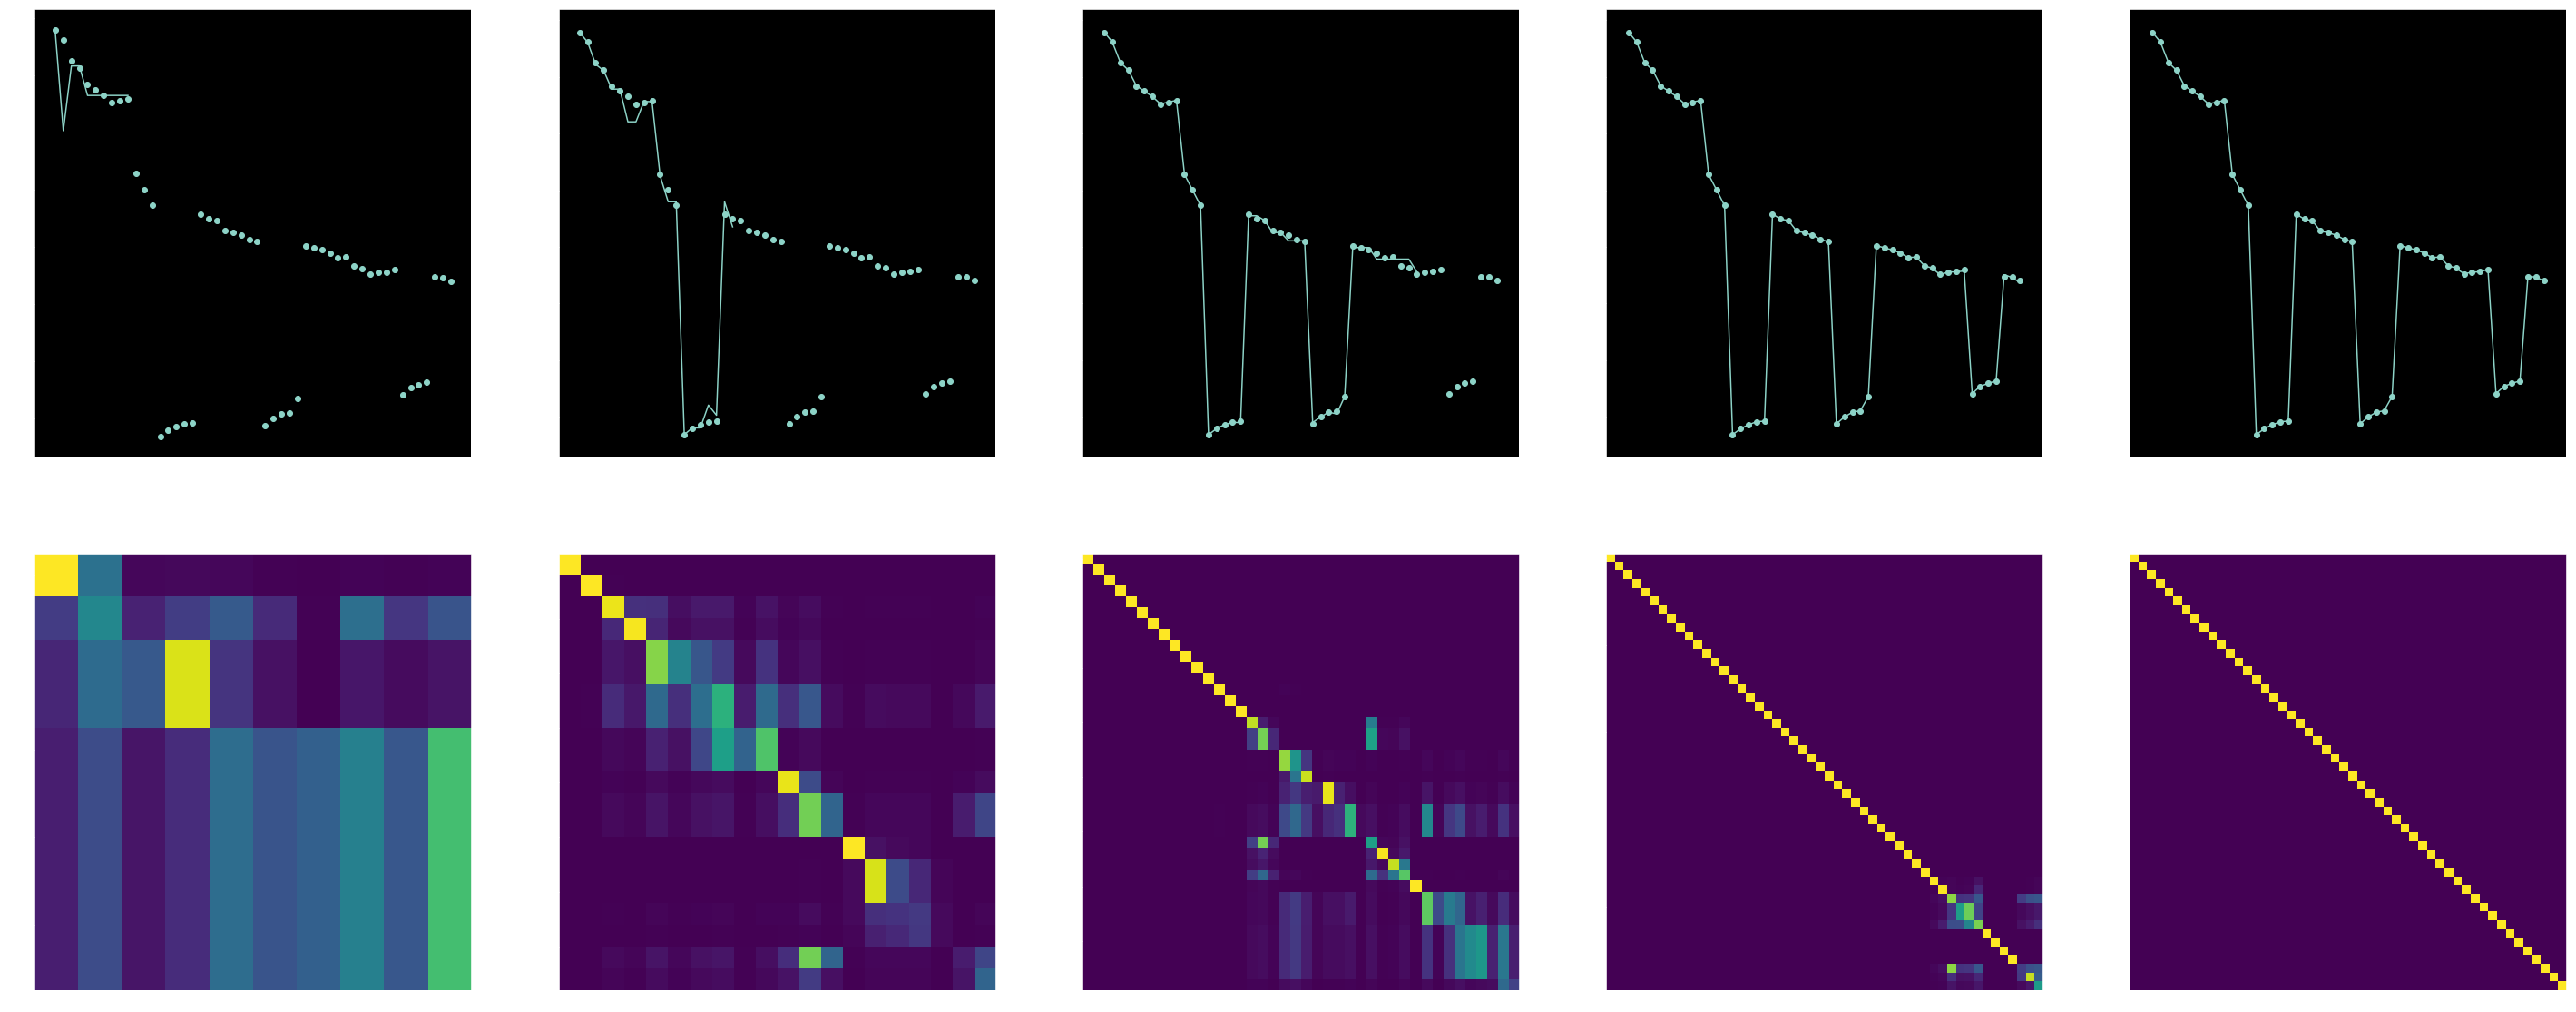

In [12]:
# Batch Lanczos
fig, ax = plt.subplots(2,len(neigens), figsize=(10*len(neigens),20))
results = {}

for i,neigen in enumerate(neigens):
    b_eig_val, b_eig_vec = batch_hessian_eigen(model, ds, loss_fn, neigen)
    ort_err, vec_err, val_err, mat, b_eig_val_ = align_and_compare(b_eig_vec, b_eig_val, a_eig_vec, a_eig_val, N)
    
    ax[0, i].plot(b_eig_val_.cpu().numpy())
    ax[0, i].scatter(np.arange(N), a_eig_val[:N].cpu().numpy())
    ax[1, i].imshow(mat)
    results[neigen] = ort_err, vec_err, val_err

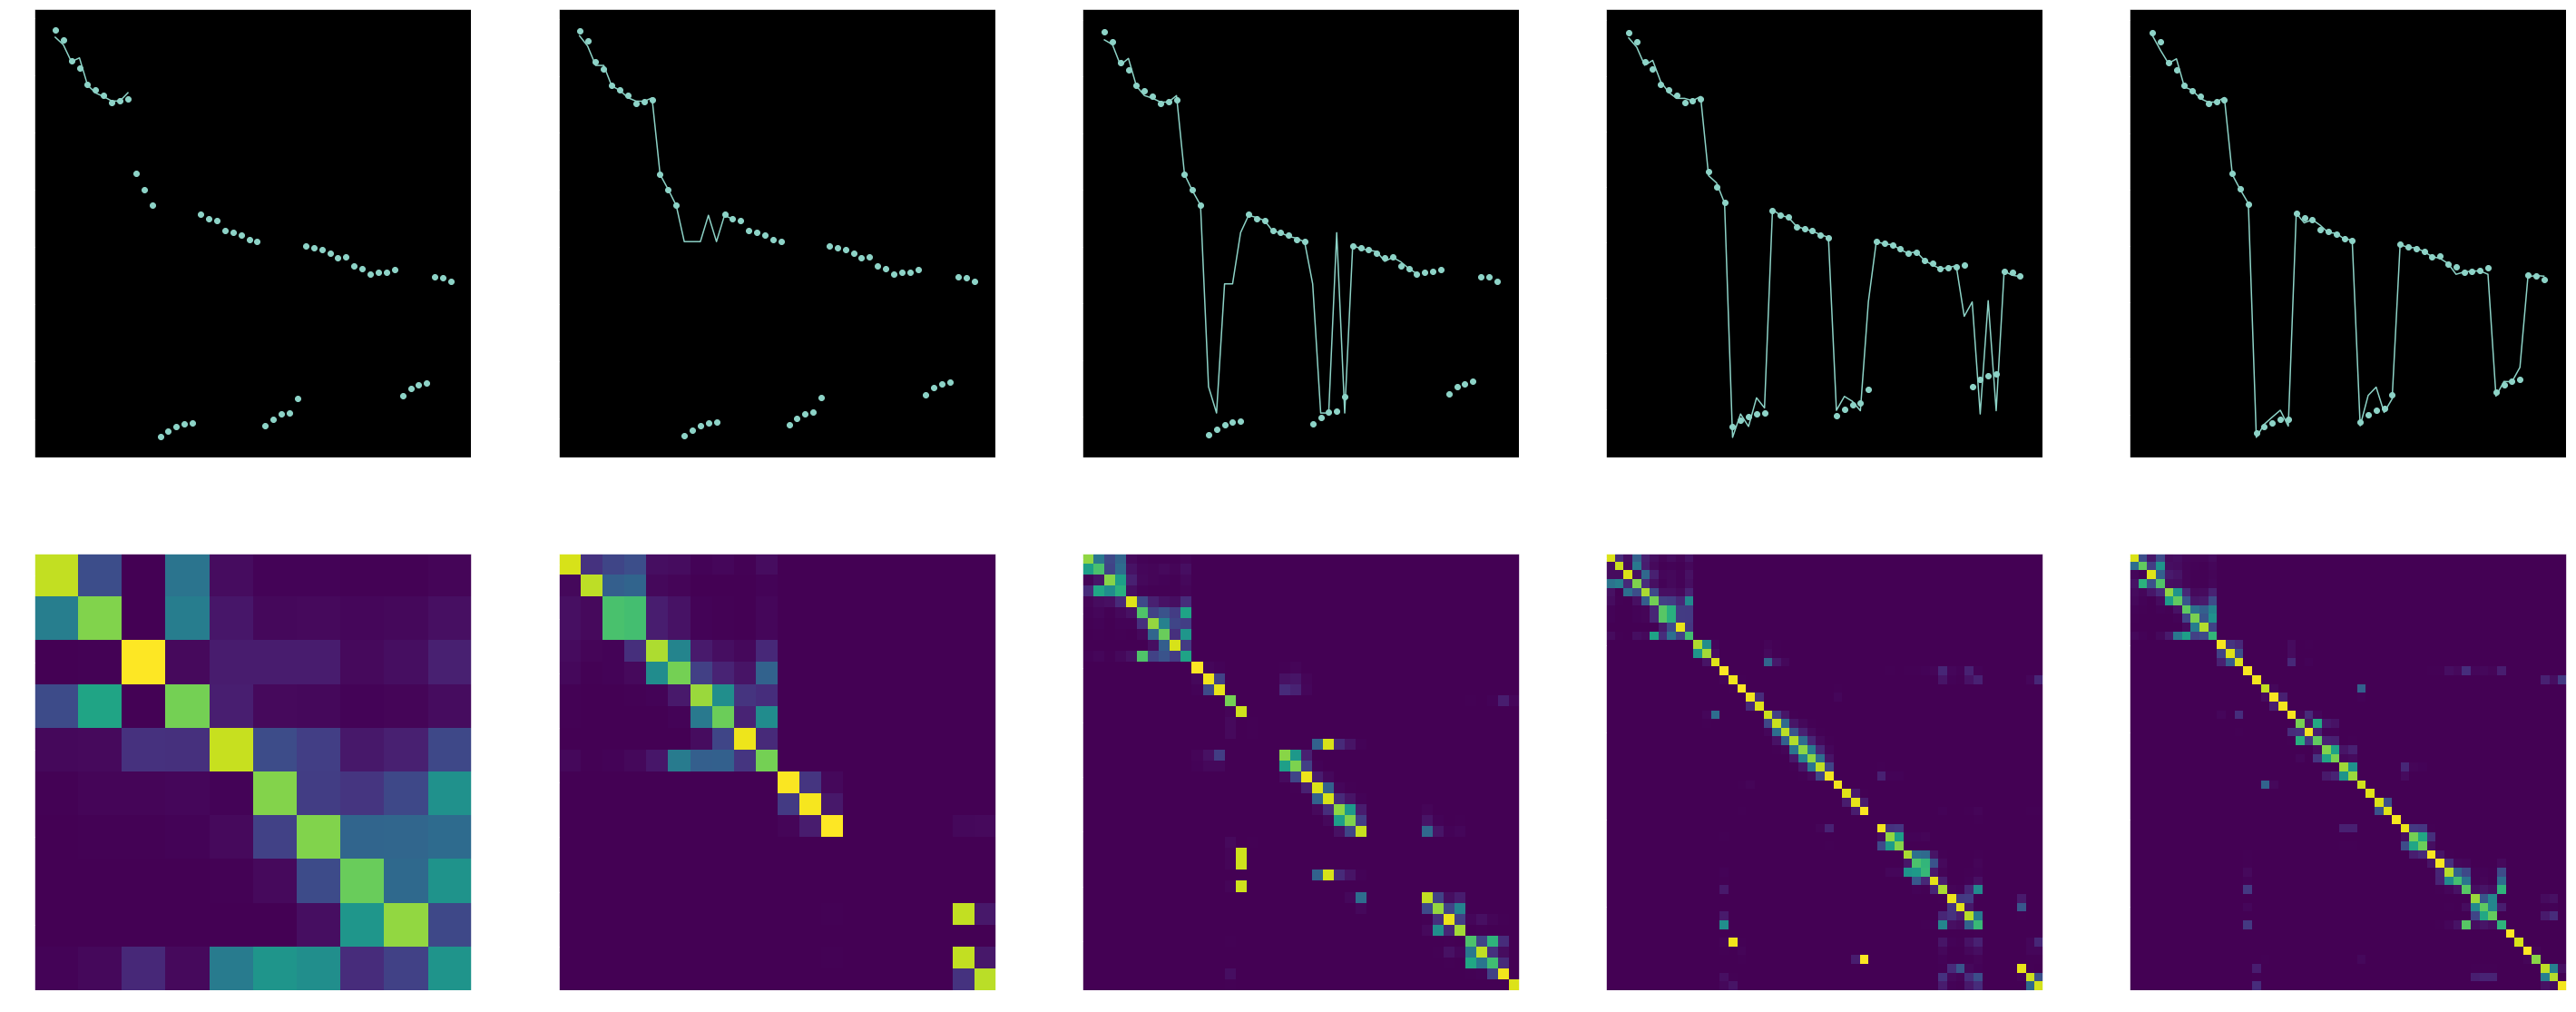

In [23]:
# Power iteration
fig, ax = plt.subplots(2,len(neigens), figsize=(10*len(neigens),20))
results = {}

for i,neigen in enumerate(neigens):
    b_eig_val, b_eig_vec = compute_hessian_eigenthings(model, ds, loss_fn, neigen, mode="power_iter")
    b_eig_val = torch.from_numpy(b_eig_val.copy()).float()#.cuda()
    b_eig_vec = torch.from_numpy(b_eig_vec.copy()).float()#.cuda()
    ort_err, vec_err, val_err, mat, b_eig_val_ = align_and_compare(b_eig_vec, b_eig_val, a_eig_vec, a_eig_val, N)
    
    ax[0, i].plot(b_eig_val_.cpu().numpy())
    ax[0, i].scatter(np.arange(N), a_eig_val[:N].cpu().numpy())
    ax[1, i].imshow(mat)
    results[neigen] = ort_err, vec_err, val_err

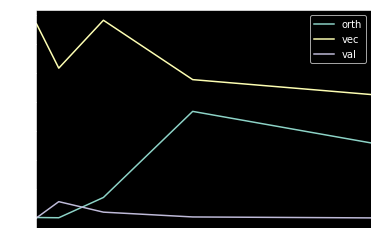

In [24]:
df = pd.DataFrame(results).T
df.columns = ["orth", "vec", "val"]
df.plot()

/home/tristan/anaconda3/envs/torch1/lib/python3.6/site-packages/hessian_eigenthings-0.0.1-py3.6.egg/hessian_eigenthings/lanczos.py:57: UserWarning: [lanczos] number of lanczos vectors should usually be > 2*num_eigenthings


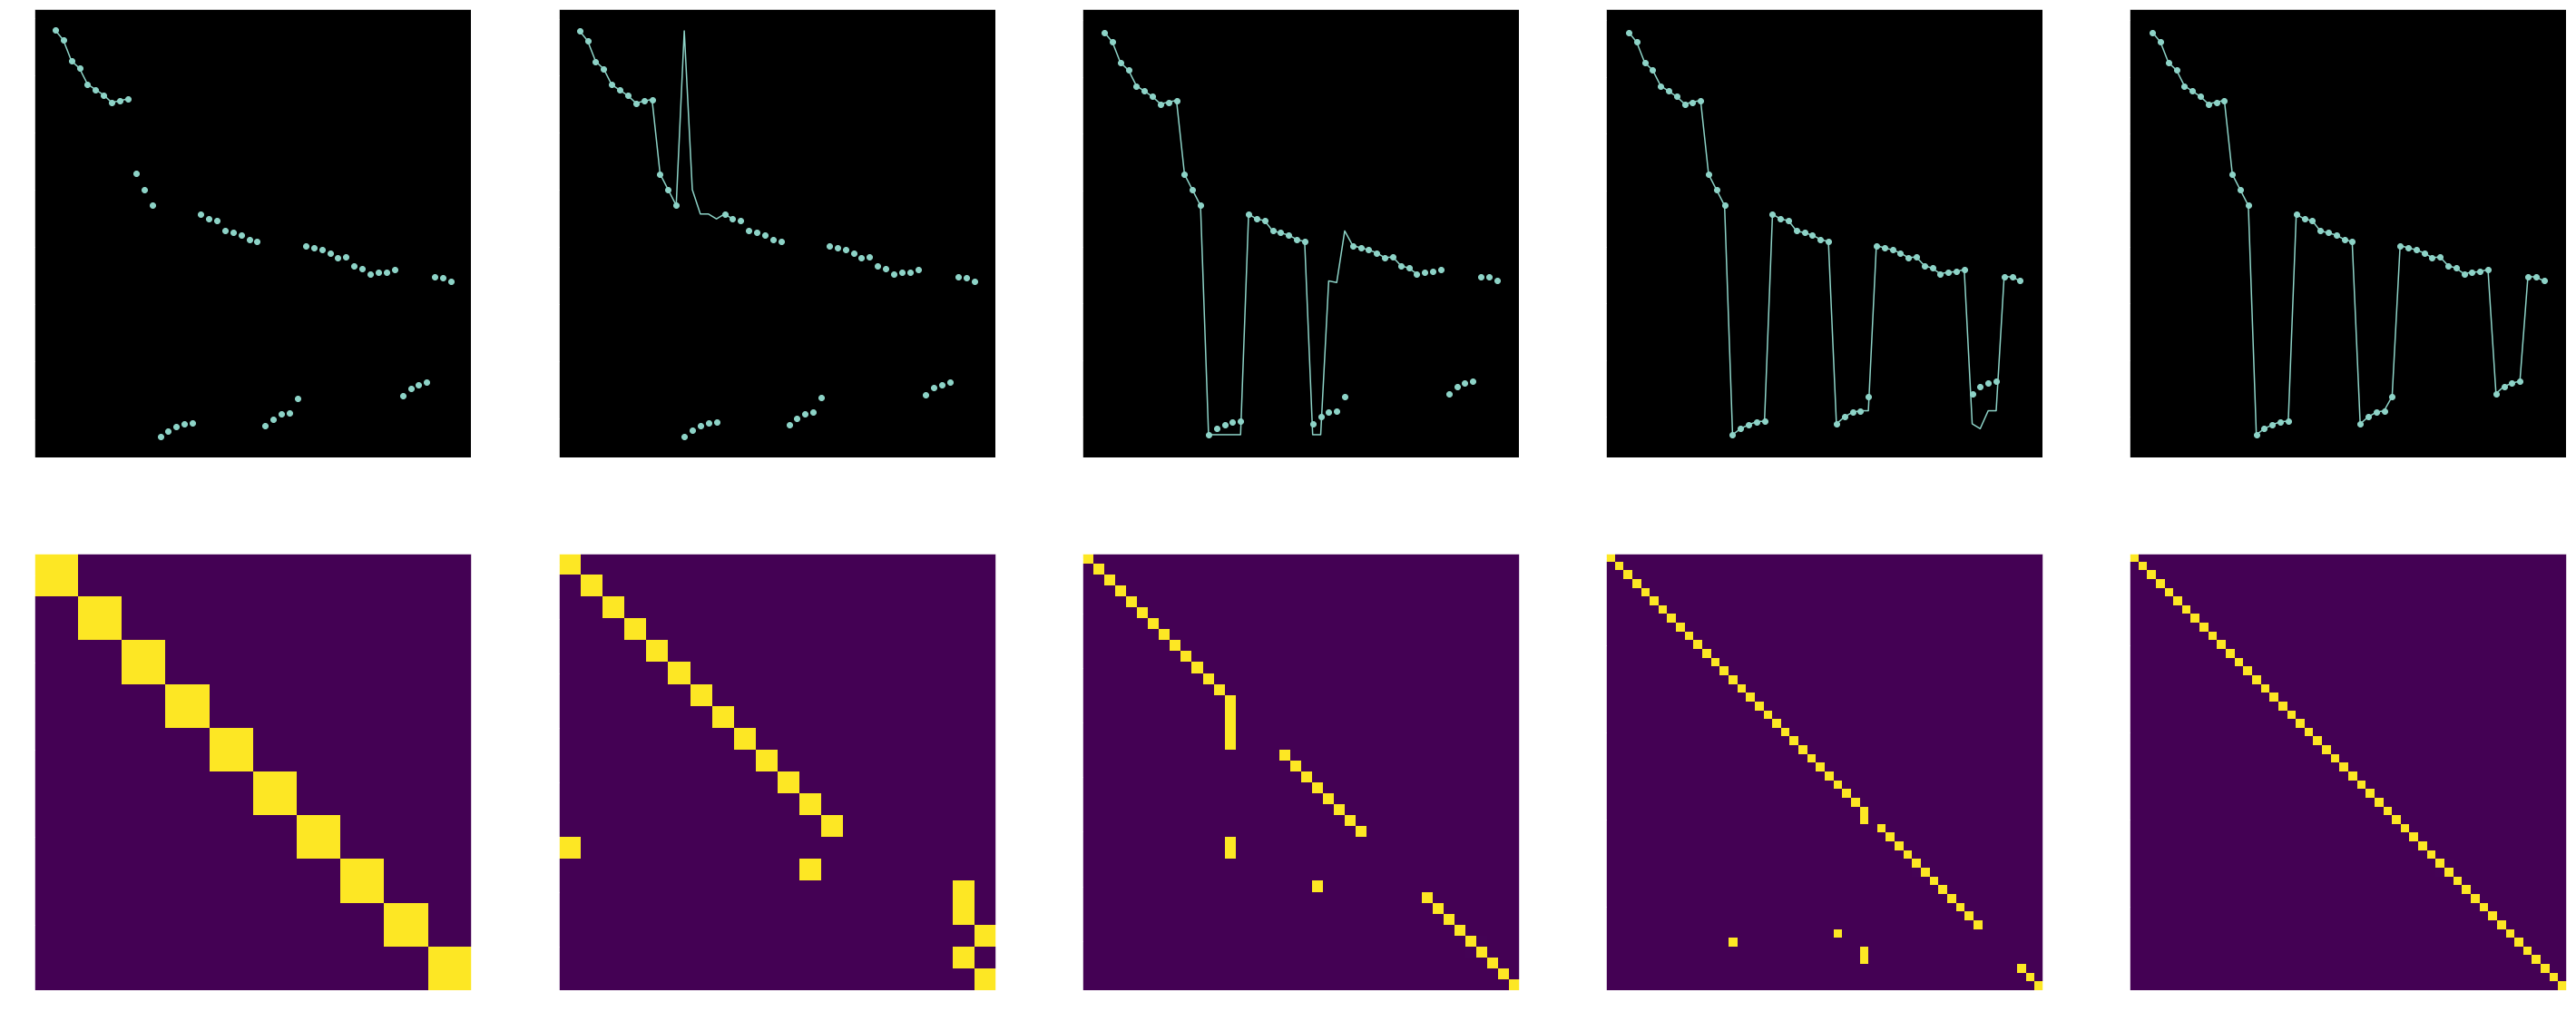

In [25]:
# Lanczos
fig, ax = plt.subplots(2,len(neigens), figsize=(10*len(neigens),20))
results = {}

for i,neigen in enumerate(neigens):
    b_eig_val, b_eig_vec = compute_hessian_eigenthings(model, ds, loss_fn, neigen, mode="lanczos")
    b_eig_val = torch.from_numpy(b_eig_val.copy()).float()#.cuda()
    b_eig_vec = torch.from_numpy(b_eig_vec.copy()).float()#.cuda()
    ort_err, vec_err, val_err, mat, b_eig_val_ = align_and_compare(b_eig_vec, b_eig_val, a_eig_vec, a_eig_val, N)
    
    ax[0, i].plot(b_eig_val_.cpu().numpy())
    ax[0, i].scatter(np.arange(N), a_eig_val[:N].cpu().numpy())
    ax[1, i].imshow(mat)
    results[neigen] = ort_err, vec_err, val_err

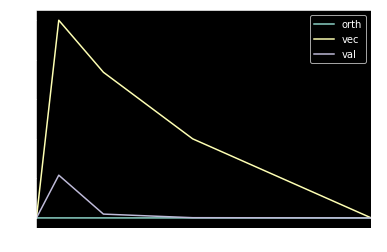

In [26]:
df = pd.DataFrame(results).T
df.columns = ["orth", "vec", "val"]
df.plot()

## 3. Impact of width

In [23]:
widths = [10, 50, 100, 200]
neigen = 80

In [24]:
ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
               out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)

Starting with width 10
Analytical solved in 0s
Approximation solved in 4s
Analysis done in 0s
Starting with width 50
Analytical solved in 1s
Approximation solved in 4s
Analysis done in 0s
Starting with width 100
Analytical solved in 5s
Approximation solved in 4s
Analysis done in 0s
Starting with width 200
Analytical solved in 25s
Approximation solved in 3s
Analysis done in 0s


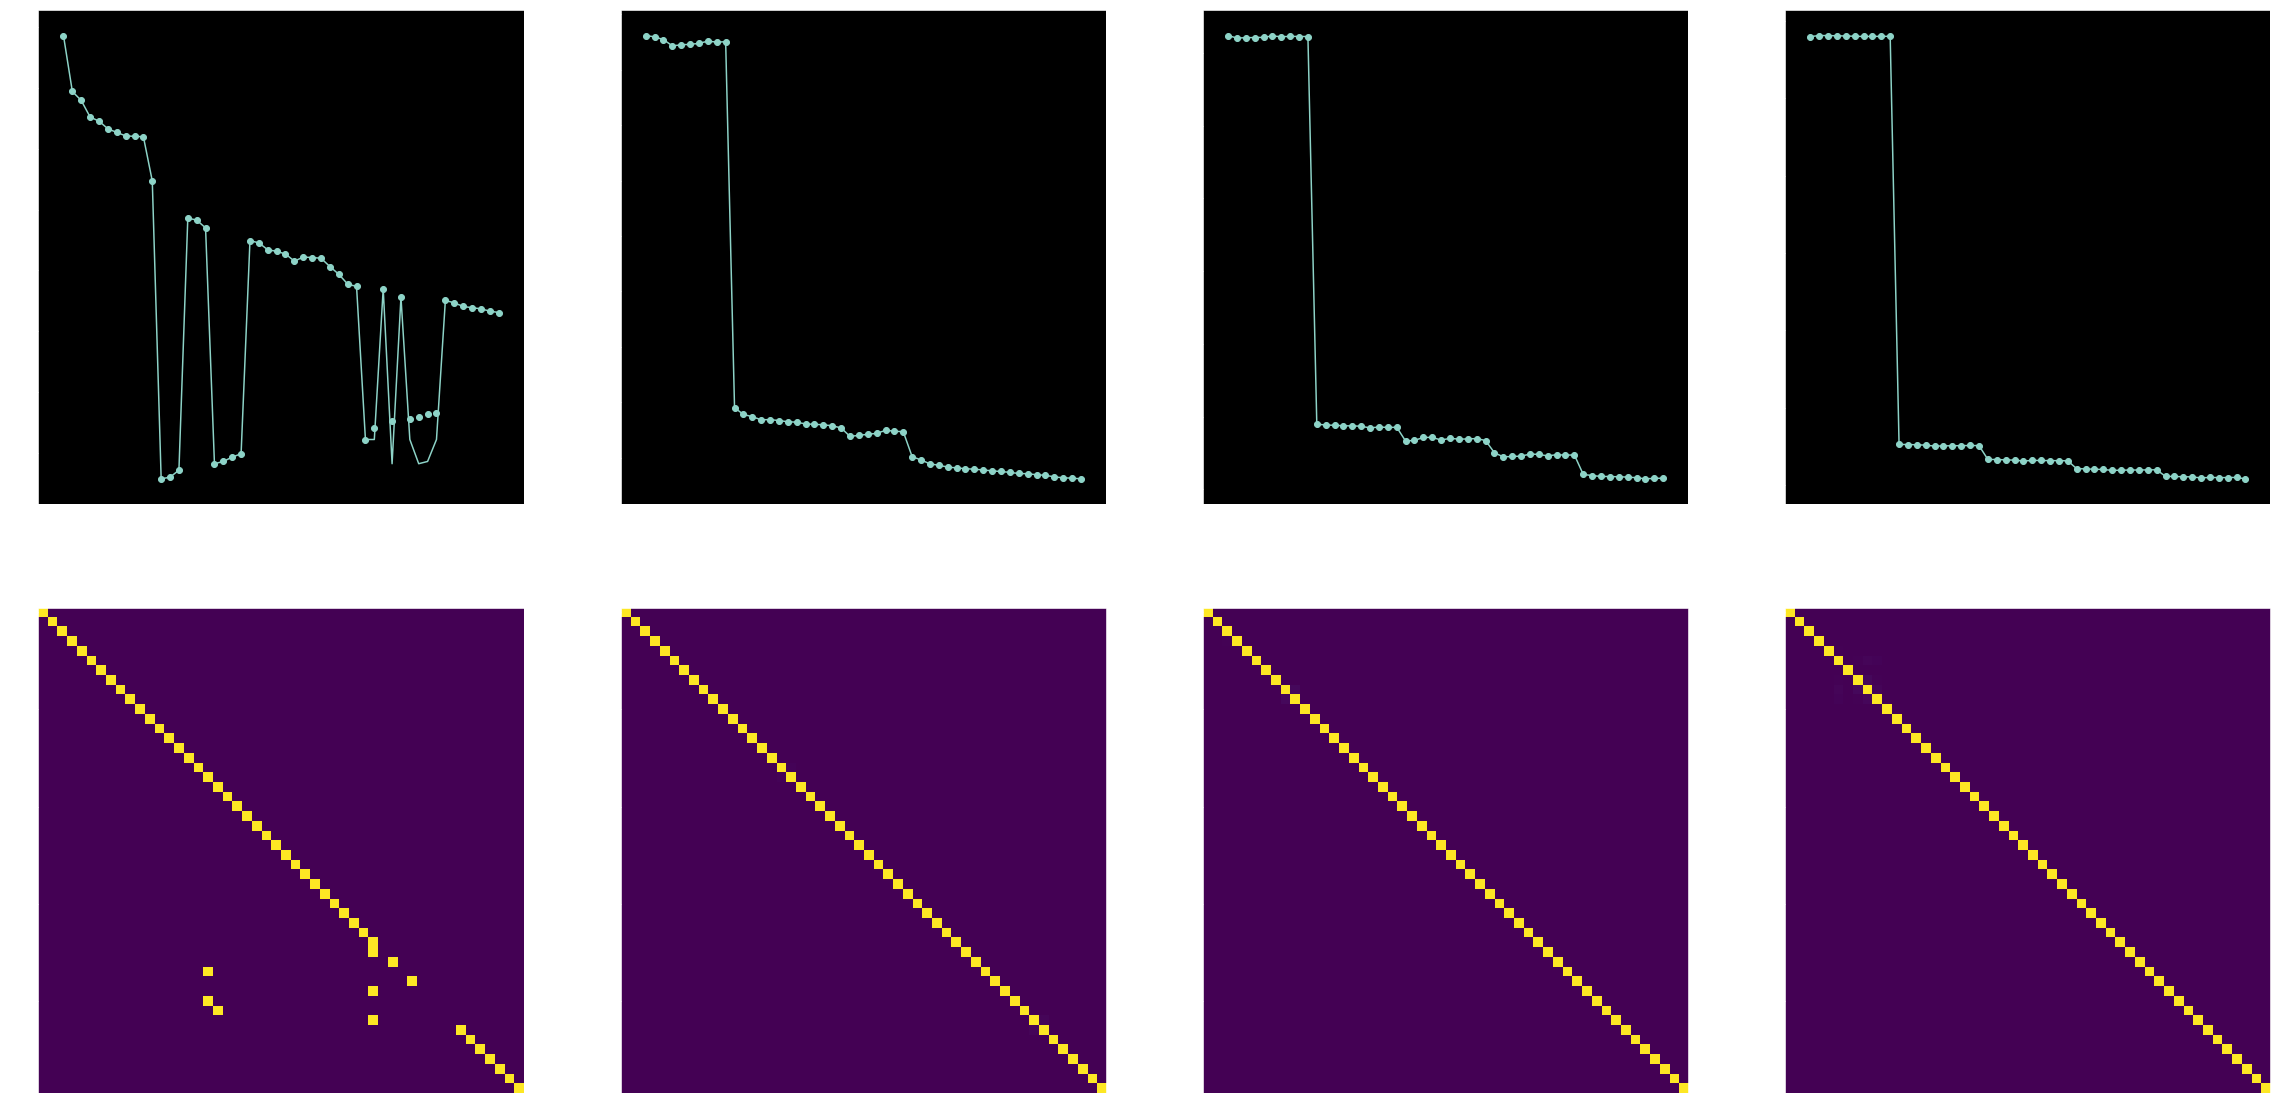

In [25]:
# Lanczos
fig, ax = plt.subplots(2,len(widths), figsize=(10*len(widths),20))
results = {}

for i,width in enumerate(widths):
    print(f"Starting with width {width}")
    model =  MLP(inp_dim, width, out_dim, nlayer, bias, mode).cuda(device)
    start = time.time()
    a_eig_val, a_eig_vec = analytic_hessian_eigen(model, ds, loss_fn)
    print(f"Analytical solved in {int(time.time()-start)}s")
    start = time.time()
    b_eig_val, b_eig_vec = compute_hessian_eigenthings(model, ds, loss_fn, neigen, mode="lanczos")
    print(f"Approximation solved in {int(time.time()-start)}s")
    start = time.time()
    b_eig_val = torch.from_numpy(b_eig_val.copy()).float()#.cuda()
    b_eig_vec = torch.from_numpy(b_eig_vec.copy()).float()#.cuda()
    ort_err, vec_err, val_err, mat, b_eig_val_ = align_and_compare(b_eig_vec, b_eig_val, a_eig_vec, a_eig_val, N)
    
    ax[0, i].plot(b_eig_val_.cpu().numpy())
    ax[0, i].scatter(np.arange(N), a_eig_val[:N].cpu().numpy())
    ax[1, i].imshow(mat)
    results[width] = ort_err, vec_err, val_err
    print(f"Analysis done in {int(time.time()-start)}s")

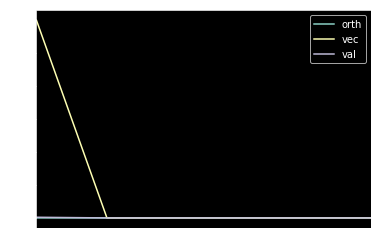

In [26]:
df = pd.DataFrame(results).T
df.columns = ["orth", "vec", "val"]
df.plot()

Starting with width 10


 10%|█         | 8/79 [00:00<00:00, 78.18it/s]

Analytical solved in 0s
[Complete LANCZOS Algorithm running]


100%|██████████| 79/79 [00:00<00:00, 87.58it/s]


Approximation solved in 0s
Analysis done in 0s
Starting with width 50


 29%|██▉       | 23/79 [00:00<00:00, 221.41it/s]

Analytical solved in 2s
[Complete LANCZOS Algorithm running]


100%|██████████| 79/79 [00:00<00:00, 79.60it/s]


Approximation solved in 0s
Analysis done in 0s
Starting with width 100


 30%|███       | 24/79 [00:00<00:00, 226.49it/s]

Analytical solved in 5s
[Complete LANCZOS Algorithm running]


100%|██████████| 79/79 [00:00<00:00, 115.90it/s]


Approximation solved in 0s
Analysis done in 0s
Starting with width 200


 28%|██▊       | 22/79 [00:00<00:00, 219.88it/s]

Analytical solved in 25s
[Complete LANCZOS Algorithm running]


100%|██████████| 79/79 [00:00<00:00, 109.90it/s]


Approximation solved in 0s
Analysis done in 0s


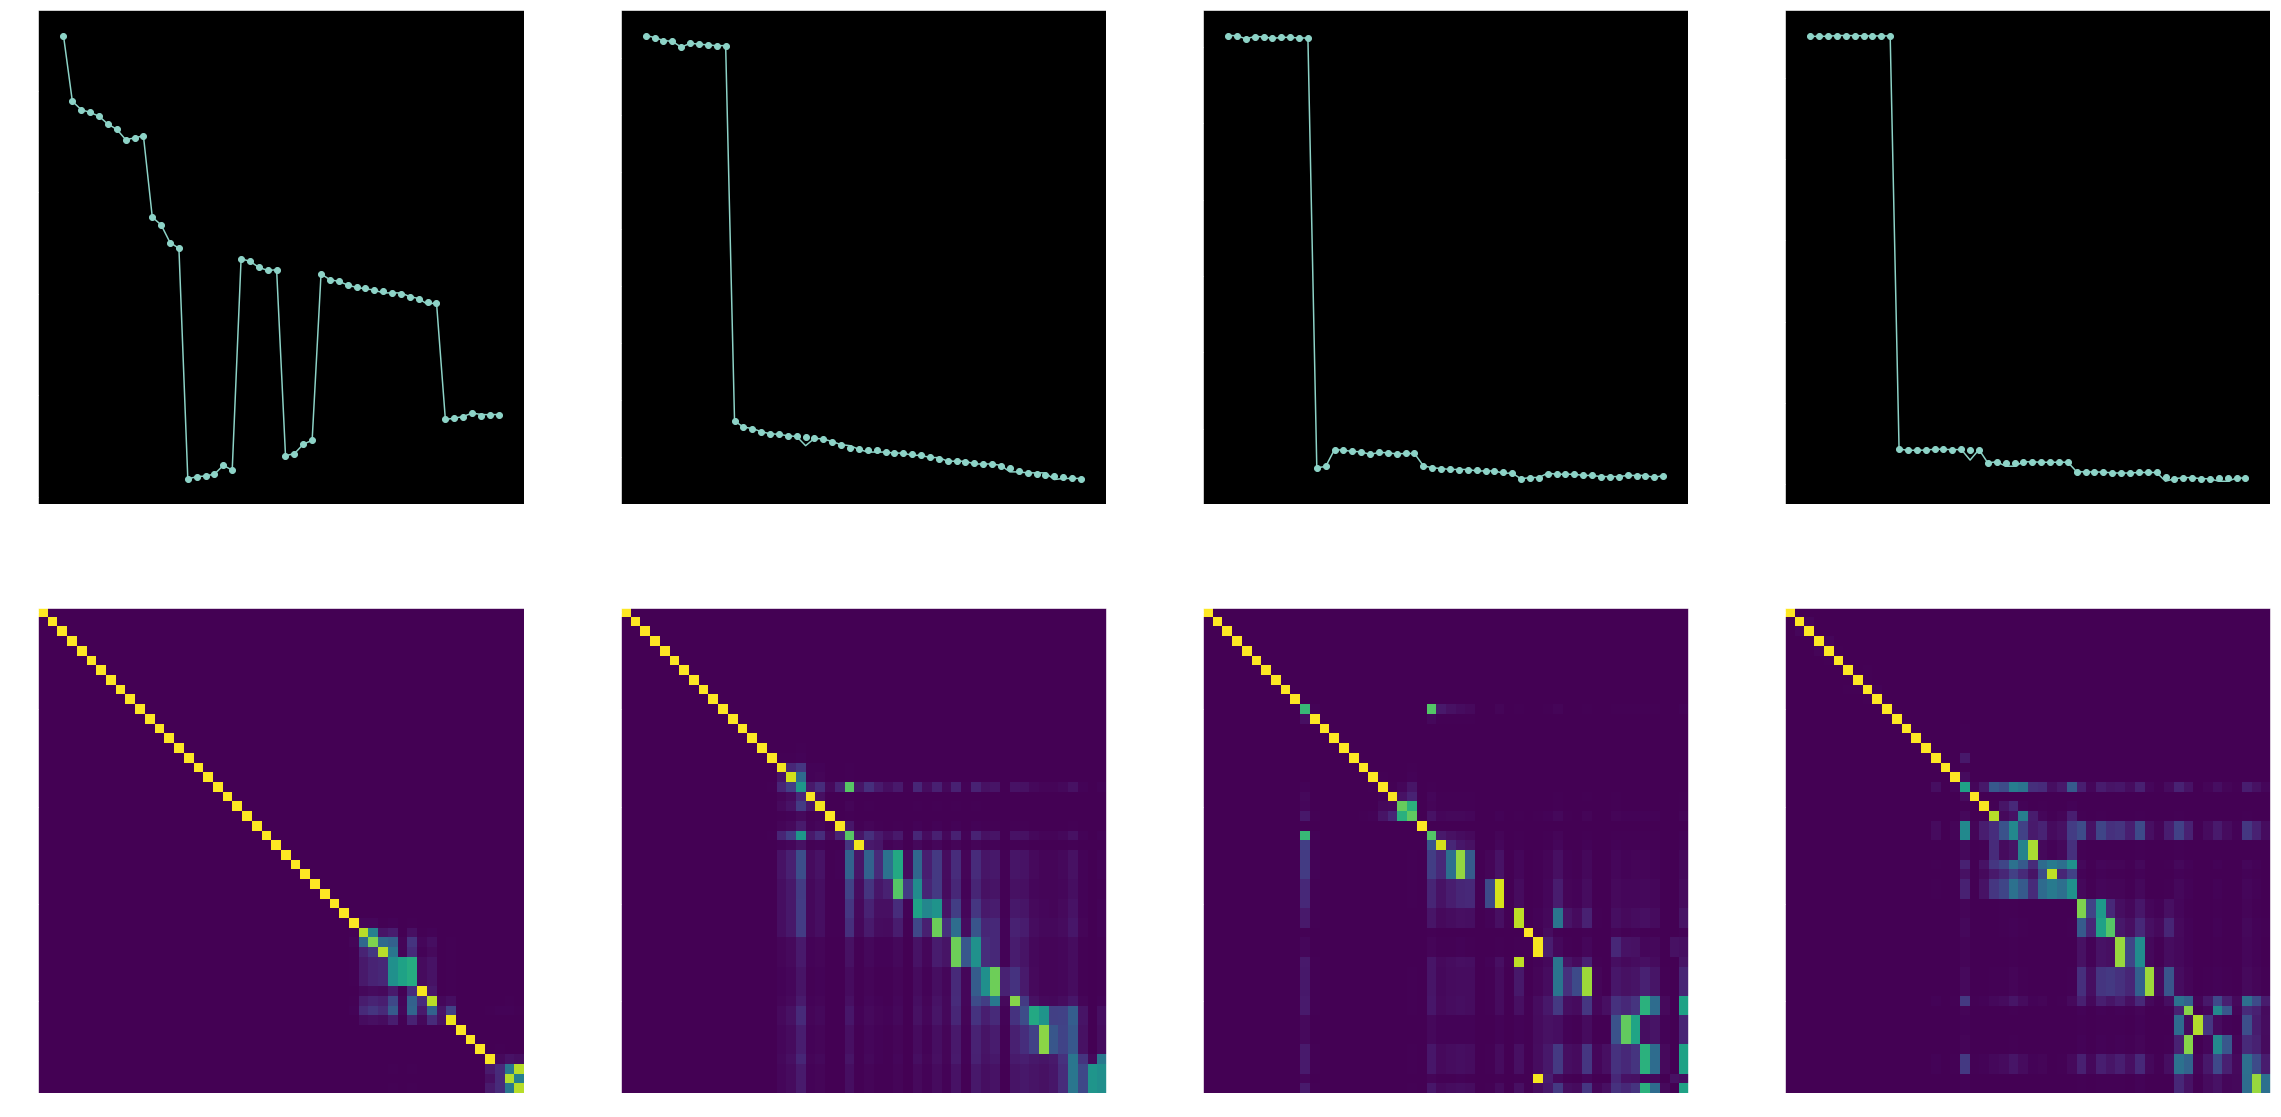

In [27]:
# Batch Lanczos
fig, ax = plt.subplots(2,len(widths), figsize=(10*len(widths),20))
results = {}

for i,width in enumerate(widths):
    print(f"Starting with width {width}")
    model =  MLP(inp_dim, width, out_dim, nlayer, bias, mode).cuda(device)
    start = time.time()
    a_eig_val, a_eig_vec = analytic_hessian_eigen(model, ds, loss_fn)
    print(f"Analytical solved in {int(time.time()-start)}s")
    start = time.time()
    b_eig_val, b_eig_vec = batch_hessian_eigen(model, ds, loss_fn, neigen)
    print(f"Approximation solved in {int(time.time()-start)}s")
    start = time.time()
    ort_err, vec_err, val_err, mat, b_eig_val_ = align_and_compare(b_eig_vec, b_eig_val, a_eig_vec, a_eig_val, N)
    
    ax[0, i].plot(b_eig_val_.cpu().numpy())
    ax[0, i].scatter(np.arange(N), a_eig_val[:N].cpu().numpy())
    ax[1, i].imshow(mat)
    results[width] = ort_err, vec_err, val_err
    print(f"Analysis done in {int(time.time()-start)}s")

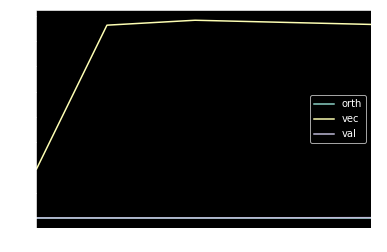

In [29]:
df = pd.DataFrame(results).T
df.columns = ["orth", "vec", "val"]
df.plot()

## 4. Impact of depth

In [31]:
width = 40
neigen = 80
depths = [2, 3, 4]
N = 50

In [32]:
ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
               out_dim, nsamp, device)
loss_fn = SquaredClassification(out_dim)

Starting with depth 2
Analytical solved in 1s
Approximation solved in 4s
Analysis done in 0s
Starting with depth 3
Analytical solved in 8s
Approximation solved in 5s
Analysis done in 0s
Starting with depth 4
Analytical solved in 44s
Approximation solved in 7s
Analysis done in 0s


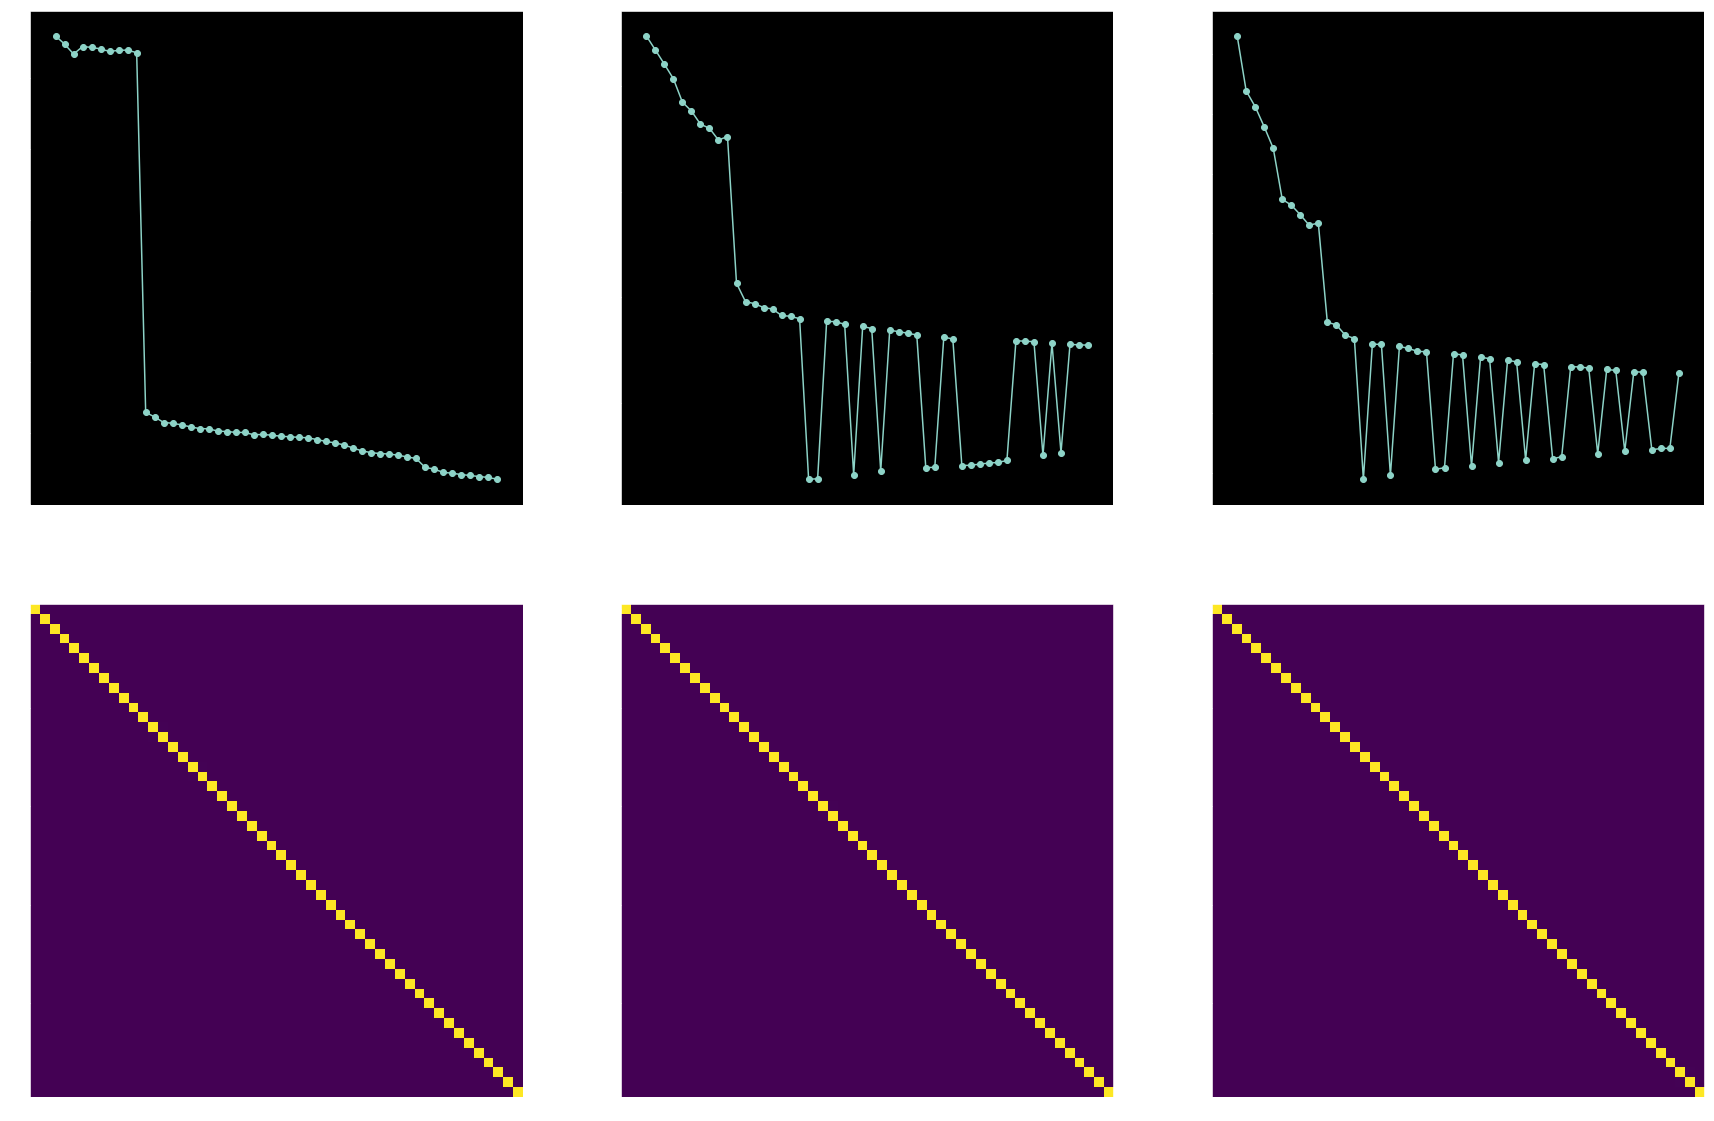

In [33]:
# Lanczos
fig, ax = plt.subplots(2,len(depths), figsize=(10*len(depths),20))
results = {}

for i,depth in enumerate(depths):
    print(f"Starting with depth {depth}")
    model =  MLP(inp_dim, width, out_dim, depth, bias, mode).cuda(device)
    start = time.time()
    a_eig_val, a_eig_vec = analytic_hessian_eigen(model, ds, loss_fn)
    print(f"Analytical solved in {int(time.time()-start)}s")
    start = time.time()
    b_eig_val, b_eig_vec = compute_hessian_eigenthings(model, ds, loss_fn, neigen, mode="lanczos")
    print(f"Approximation solved in {int(time.time()-start)}s")
    start = time.time()
    b_eig_val = torch.from_numpy(b_eig_val.copy()).float()
    b_eig_vec = torch.from_numpy(b_eig_vec.copy()).float()
    ort_err, vec_err, val_err, mat, b_eig_val_ = align_and_compare(b_eig_vec, b_eig_val, a_eig_vec, a_eig_val, N)
    
    ax[0, i].plot(b_eig_val_.cpu().numpy())
    ax[0, i].scatter(np.arange(N), a_eig_val[:N].cpu().numpy())
    ax[1, i].imshow(mat)
    results[depth] = ort_err, vec_err, val_err
    print(f"Analysis done in {int(time.time()-start)}s")

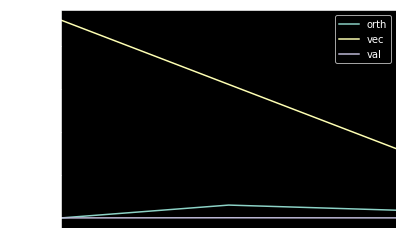

In [34]:
df = pd.DataFrame(results).T
df.columns = ["orth", "vec", "val"]
df.plot()

Starting with depth 2


 13%|█▎        | 10/79 [00:00<00:00, 99.88it/s]

Analytical solved in 1s
[Complete LANCZOS Algorithm running]


100%|██████████| 79/79 [00:00<00:00, 87.65it/s]


Approximation solved in 0s
Analysis done in 0s
Starting with depth 3


 22%|██▏       | 17/79 [00:00<00:00, 159.25it/s]

Analytical solved in 12s
[Complete LANCZOS Algorithm running]


100%|██████████| 79/79 [00:00<00:00, 82.19it/s]


Approximation solved in 0s
Analysis done in 0s
Starting with depth 4


 23%|██▎       | 18/79 [00:00<00:00, 177.45it/s]

Analytical solved in 26s
[Complete LANCZOS Algorithm running]


100%|██████████| 79/79 [00:00<00:00, 95.60it/s]


Approximation solved in 0s
Analysis done in 0s


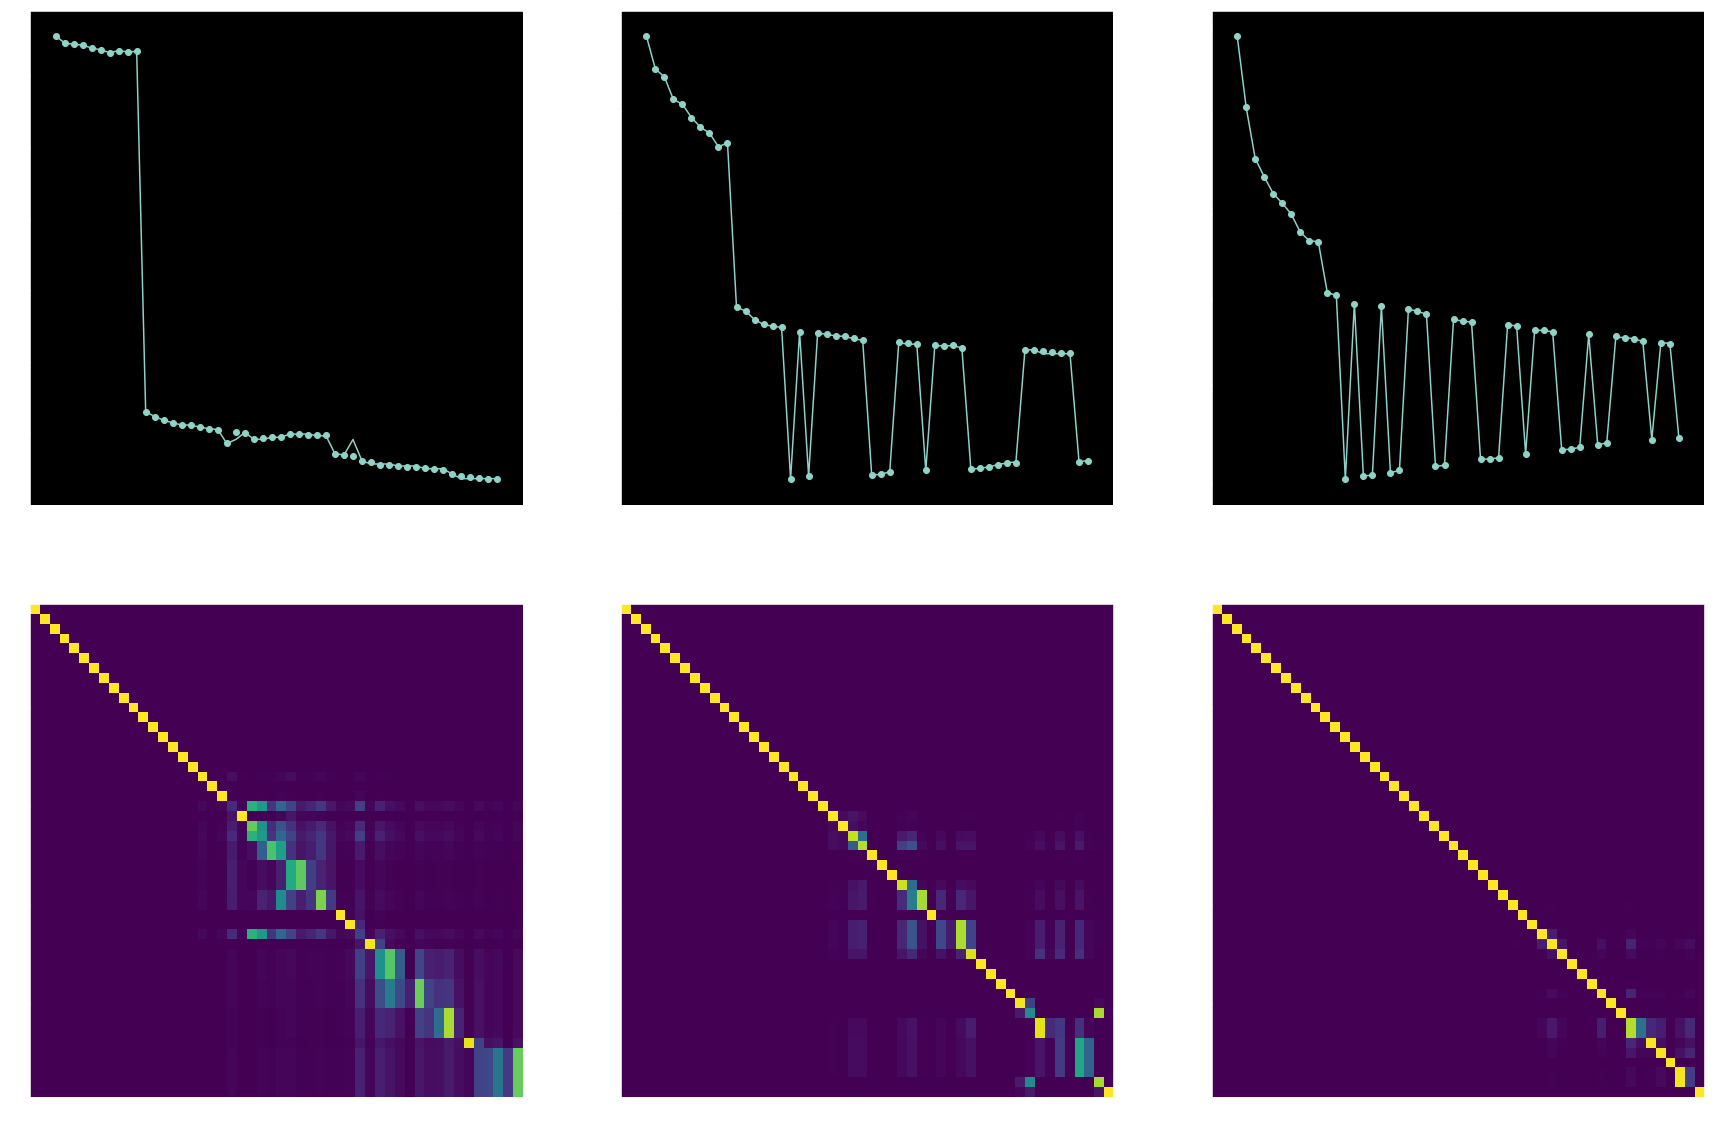

In [35]:
# Batch Lanczos
fig, ax = plt.subplots(2,len(depths), figsize=(10*len(depths),20))
results = {}

for i,depth in enumerate(depths):
    print(f"Starting with depth {depth}")
    model =  MLP(inp_dim, width, out_dim, depth, bias, mode).cuda(device)
    start = time.time()
    a_eig_val, a_eig_vec = analytic_hessian_eigen(model, ds, loss_fn)
    print(f"Analytical solved in {int(time.time()-start)}s")
    start = time.time()
    b_eig_val, b_eig_vec = batch_hessian_eigen(model, ds, loss_fn, neigen)
    print(f"Approximation solved in {int(time.time()-start)}s")
    start = time.time()
    ort_err, vec_err, val_err, mat, b_eig_val_ = align_and_compare(b_eig_vec, b_eig_val, a_eig_vec, a_eig_val, N)
    
    ax[0, i].plot(b_eig_val_.cpu().numpy())
    ax[0, i].scatter(np.arange(N), a_eig_val[:N].cpu().numpy())
    ax[1, i].imshow(mat)
    results[depth] = ort_err, vec_err, val_err
    print(f"Analysis done in {int(time.time()-start)}s")

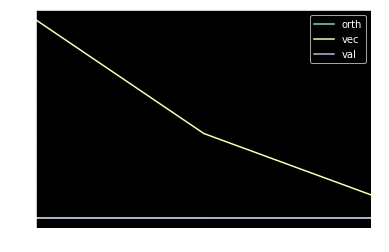

In [36]:
df = pd.DataFrame(results).T
df.columns = ["orth", "vec", "val"]
df.plot()